In [1]:
# Remove warnings
import warnings

warnings.filterwarnings('ignore')

# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

# Linear algrebra
import numpy as np
import pywt
# ML and Metrics module
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Data APIs
import yfinance as yf
from pytrends.request import TrendReq

# Technical indicators
from ta.momentum import rsi, stochrsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import ease_of_movement
from scipy.signal import savgol_filter, convolve, lfilter


from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope

Loading BokehJS ...

# Load the data

In [2]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/Binance/1h/{SYMBOL}-USDT.csv')
df = computeLaggingLinearRegression(df,window=5,filter_ceof=True, derivative=True,filter_method='savgol')
#df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff
Date,,,,,,,,,
2020-06-01 10:00:00,9571.18,9581.99,9530.00,9540.30,1599.646355,1590998400,0.000556,0.000349,-0.001240
2020-06-01 11:00:00,9540.54,9561.69,9528.62,9541.21,1441.318955,1591002000,0.000476,0.000115,-0.000945
2020-06-01 12:00:00,9541.71,9550.00,9513.36,9543.24,1575.797277,1591005600,0.000314,-0.000019,-0.000656
2020-06-01 13:00:00,9542.32,9552.14,9511.00,9513.22,1424.183732,1591009200,-0.000531,-0.000030,-0.000379
2020-06-01 14:00:00,9512.80,9590.26,9491.45,9555.01,3042.940788,1591012800,-0.003154,-0.000155,-0.000270


<AxesSubplot:>

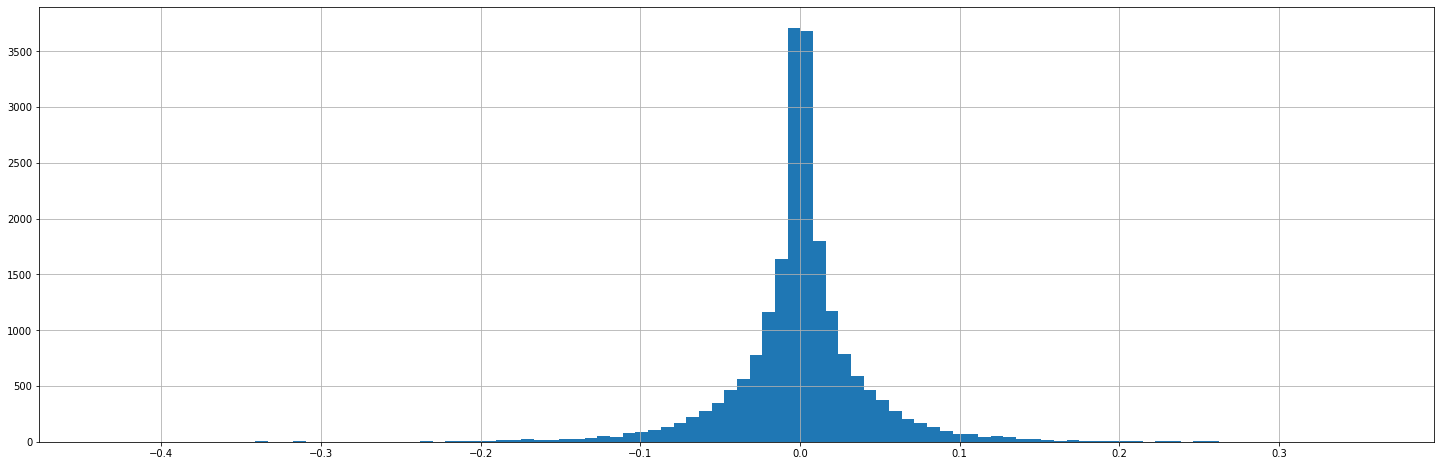

In [3]:
plt.figure(figsize=(25,8))
df.B_MLR_coefs.hist(bins=100)

In [4]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count
 
def loop_step(thresholds):
   def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
      return True if row.B_MLR_coefs<-thresholds['Buy_threshold'] else False
   def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
      return True if row.B_MLR_coefs>thresholds['Sell_threshold'] else False
   
   coins = strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)
   step = {'Buy_threshold':thresholds['Buy_threshold'],
           'Sell_threshold':thresholds['Sell_threshold'],
           'coins':coins}
   print(step)
   return step
 
possibilities = [{'Buy_threshold':-i/1000,'Sell_threshold':j/1000} for i in range(1,100,10) for j in range(1,100,10)]
print(f'Number of possibilities to test: {len(possibilities)}')

with ThreadPoolExecutor(20) as executor:
    results = [result for result in executor.map(loop_step, possibilities)]

results_df = pd.DataFrame(results)
results_df.sort_values('coins',ascending=False).head(10)

Number of possibilities to test: 100
{'Buy_threshold': -0.011, 'Sell_threshold': 0.091, 'coins': 2437.83}
{'Buy_threshold': -0.001, 'Sell_threshold': 0.091, 'coins': 2510.78}
{'Buy_threshold': -0.001, 'Sell_threshold': 0.081, 'coins': 2699.73}
{'Buy_threshold': -0.011, 'Sell_threshold': 0.081, 'coins': 2582.15}


/!\ There is no Bad Trades in your BackTest, maybe a problem...
Period : [2020-06-10 18:00:00] -> [2022-09-23 14:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 1255.16 $
Performance vs US Dollar : 25.52 %
Buy and Hold Performence : 92.99 %
Performance vs Buy and Hold : -72.56 %
Best trade : +25.69 %, the 2021-02-09 05:00:00
Worst trade : 0 %, the 
Worst drawBack : -0.0 %
Total fees :  2.46 $

----- Trades Informations -----
Total trades on period : 1
Number of positive trades : 1
Number of negative trades :  0
Trades win rate ratio : 100.0 %
Average trades performance : 25.69 %
Average positive trades : 25.69 %
Average negative trades : 0 %

----- Plot -----


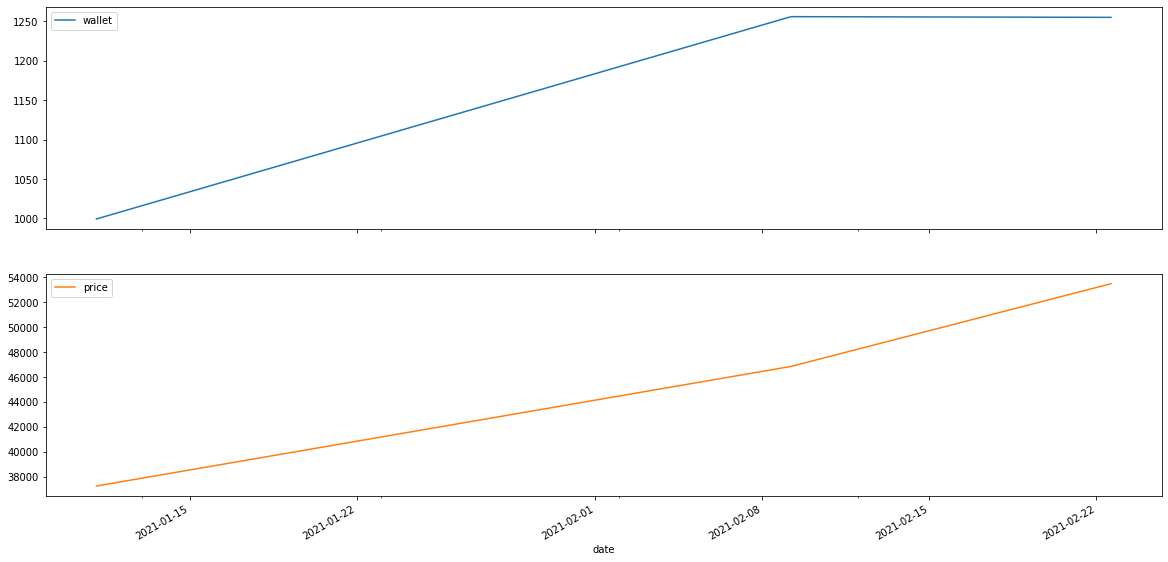

In [4]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.B_MLR_coefs<-0.03 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.B_MLR_coefs>0.09 else False
strategyTester(df,buyCondition,sellCondition,equity=1000,)

In [7]:
df['EMA20_denoised'] = savgol_filter(df.EMA20.values, 30, 2, mode='nearest')
df['EMA20_diff'] = df.EMA20_denoised.diff(1)

# Drawing Lines

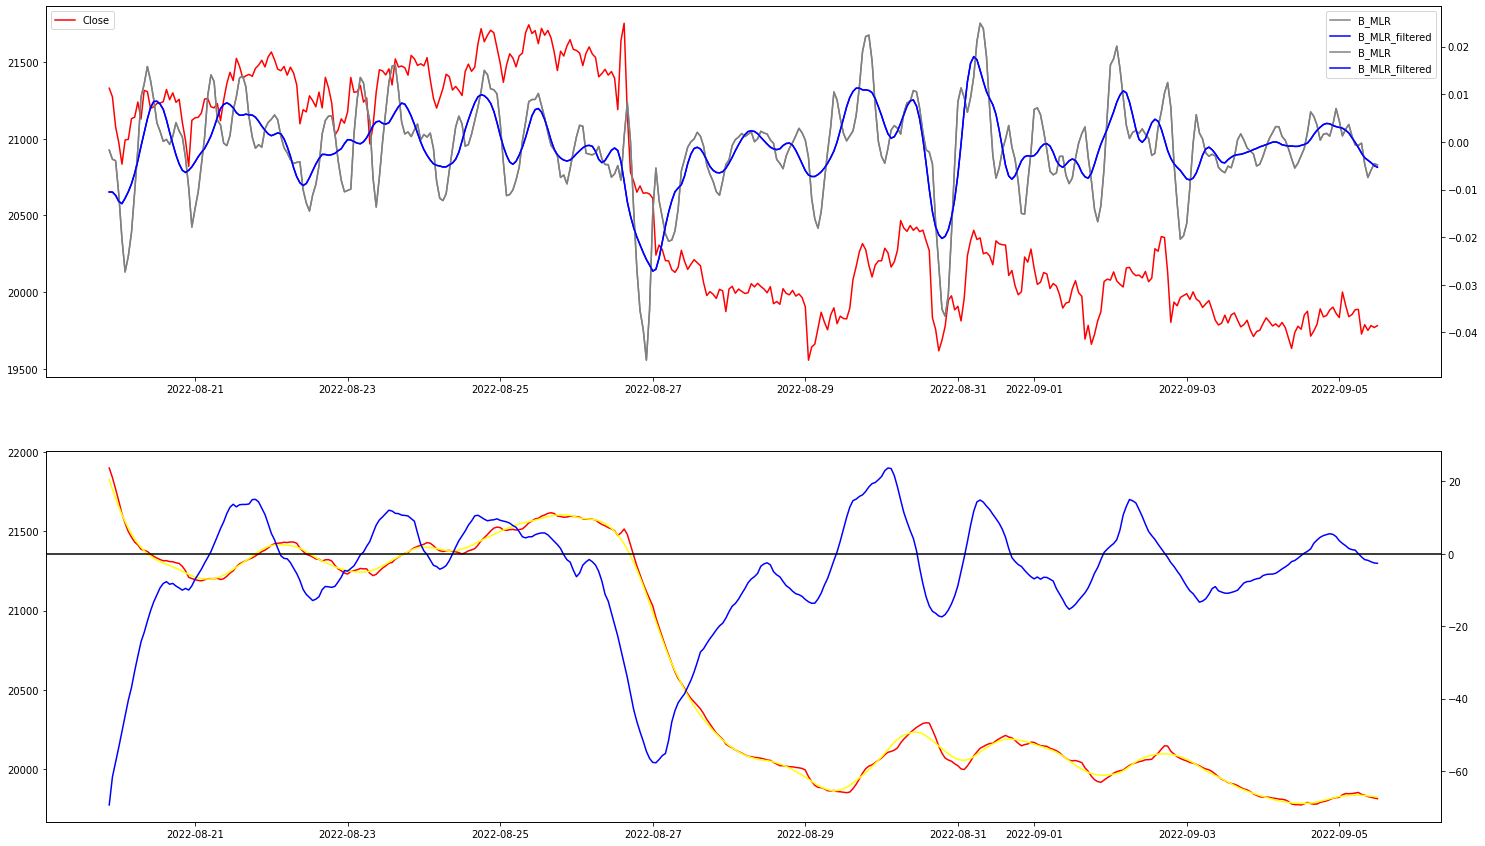

In [8]:
fig, ax_left = plt.subplots(2, figsize=(25,15))
ax_right =[]

ax_right.append(ax_left[0].twinx())
ax_right.append(ax_left[1].twinx())

ax_left[0].plot(df.Close[-400:], color='red',label='Close')
ax_right[0].plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right[0].plot(df.B_MLR_coefs_filtered[-400:], color='blue',label='B_MLR_filtered')
ax_left[0].legend(loc="upper left")
ax_right[0].plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right[0].plot(df.B_MLR_coefs_filtered[-400:], color='blue',label='B_MLR_filtered')
ax_right[0].legend(loc="upper right")

ax_left[1].plot(df.EMA20[-400:], color='red',label='RSI')
ax_left[1].plot(df.EMA20_denoised[-400:], color='yellow',label='EMA50_denoised')
ax_right[1].plot(df.EMA20_diff[-400:], color='blue',label='RSI_diff')
ax_right[1].axhline(y=0, color='black')
#sns.histplot(data=df['B_MLR_coefs'], ax = ax_leRSIft[1])

# Creating a strategy

Period : [2020-01-01 12:00:00] -> [2022-09-05 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 46113620527.94 $
Performance vs US Dollar : 4611361952.79 %
Buy and Hold Performence : 174.84 %
Performance vs Buy and Hold : 2637486697.95 %
Best trade : +17.38 %, the 2020-03-13 14:00:00
Worst trade : -7.24 %, the 2021-01-13 01:00:00
Worst drawBack : -7.000000000000001 %
Total fees :  6484931283.73 $

----- Trades Informations -----
Total trades on period : 1312
Number of positive trades : 1032
Number of negative trades :  280
Trades win rate ratio : 78.66 %
Average trades performance : 1.45 %
Average positive trades : 2.02 %
Average negative trades : -0.64 %

----- Plot -----


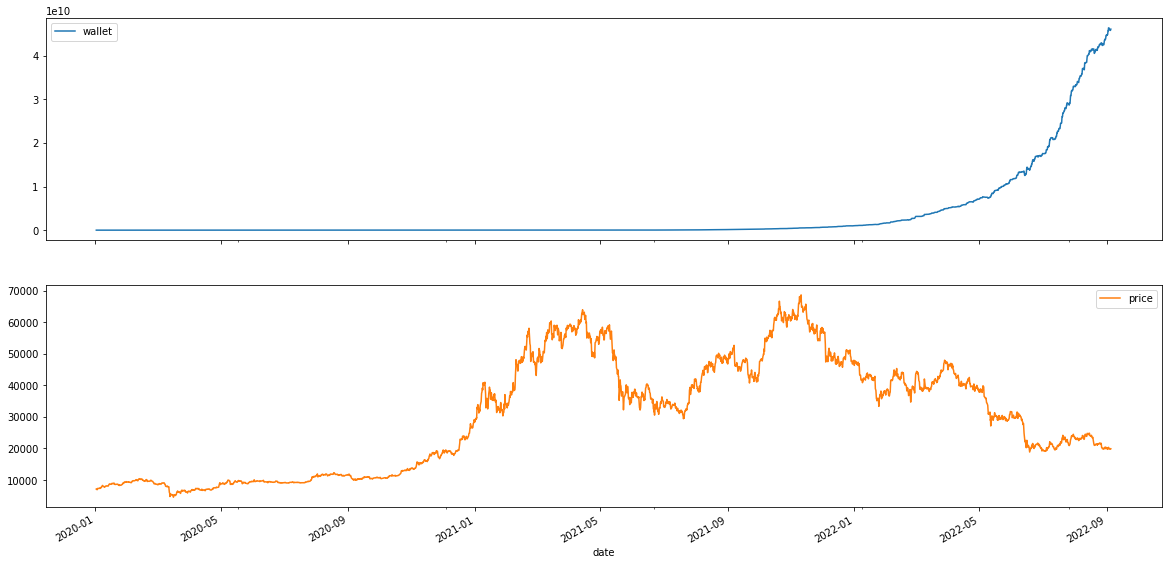

In [5]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff<0 and row.B_MLR_coefs_filtered_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff>0 and row.B_MLR_coefs_filtered_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# Optimization

In [ ]:
result = []

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff<0 and row.B_MLR_coefs_filtered_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff>0 and row.B_MLR_coefs_filtered_diff<0 else False

for i in range(5,15, 1):
    df = computeLaggingLinearRegression(loadFromDB(f'../backtest_tools/database/database/Binance/1h/{SYMBOL}-USDT.csv').iloc[-10000:],
                                        window=i,filter_ceof=True, derivative=True,filter_method='savgol')
    equity = strategyTester(df.iloc[-7000:],buyCondition,sellCondition,optimization_process=True)
    print({'window':i,'balance':equity})
    result.append({'window':i,'balance':equity})

# Denoising

In [31]:
import multiprocessing

model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0, n_jobs=multiprocessing.cpu_count())
model.fit(df.B_MLR_coefs.values.reshape(-1, 1),df.B_MLR_coefs_filtered.values)
model.score(df.B_MLR_coefs.values.reshape(-1, 1),df.B_MLR_coefs_filtered.values)

0.7363305833324558

In [7]:
len(df.B_MLR_coefs_filtered.values)

15647

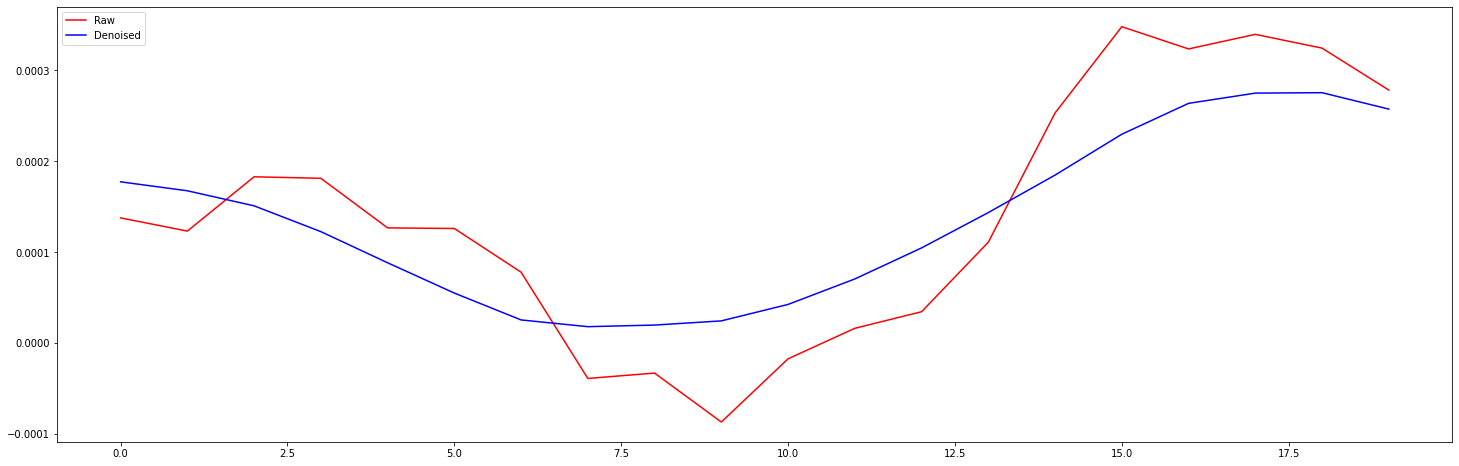

In [74]:
WINDOW=20

X = np.array([df.B_MLR_coefs.iloc[i:i+WINDOW].values for i in range(len(df)-WINDOW)])
y = np.array([df.B_MLR_coefs_filtered.iloc[i:i+WINDOW].values for i in range(len(df)-WINDOW)])

fig, ax_left = plt.subplots(1, figsize=(25,8))

ind = 165
ax_left.plot(list(range(WINDOW)),X[ind], color='red',label='Raw')
ax_left.plot(list(range(WINDOW)),y[ind], color='blue',label='Denoised')
ax_left.legend(loc="upper left")

# Denoising autoencoder

In [82]:
from keras.layers import Conv1D, Conv1DTranspose
from keras.models import Sequential
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
import multiprocessing

max_norm_value = 2.0
input_shape = (WINDOW,1 )


# Create the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='linear', padding='same'))

model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001,restore_best_weights=True,patience=4 ,verbose=1)

model.fit(X, y,
        epochs=5,
        batch_size=128,
        validation_split=0.3,
        use_multiprocessing=True,
        workers=multiprocessing.cpu_count(),
        callbacks=[es])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 18, 64)            256       
                                                                 
 conv1d_23 (Conv1D)          (None, 16, 16)            3088      
                                                                 
 conv1d_transpose_14 (Conv1D  (None, 18, 16)           784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_15 (Conv1D  (None, 20, 64)           3136      
 Transpose)                                                      
                                                                 
 conv1d_24 (Conv1D)          (None, 20, 1)             193       
                                                                 
Total params: 7,457
Trainable params: 7,457
Non-traina

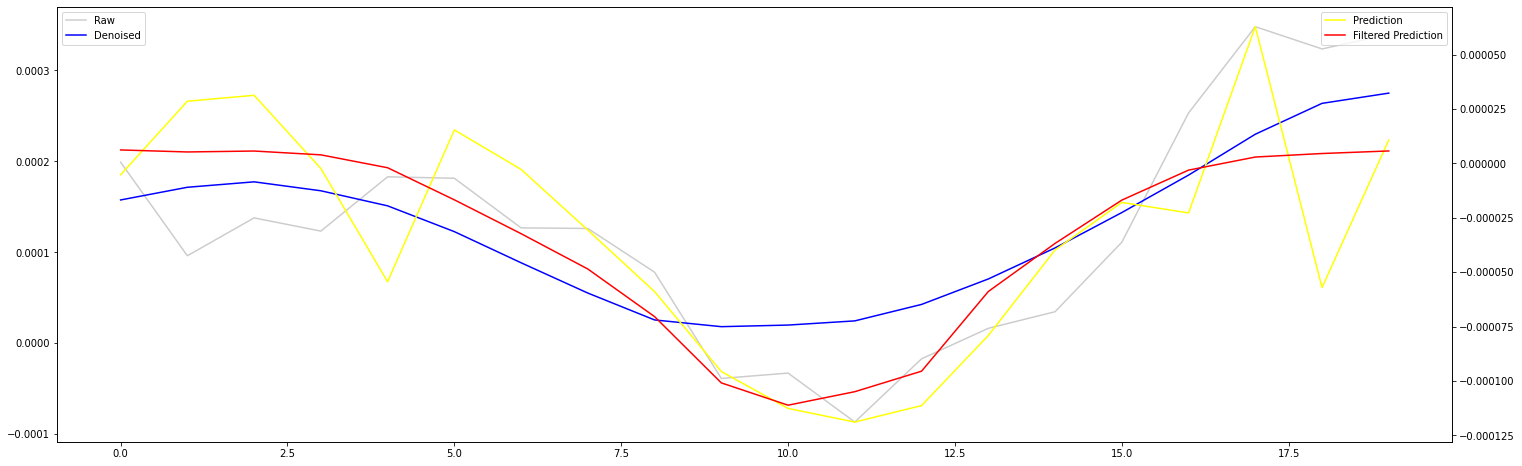

In [84]:
fig, ax_left = plt.subplots(1, figsize=(25,8))

ind = 163
ax_left.plot(list(range(WINDOW)),X[ind], color='black',alpha=0.2,label='Raw')
ax_left.plot(list(range(WINDOW)),y[ind], color='blue',label='Denoised')
ax = ax_left.twinx()
ax.plot(list(range(WINDOW)),model.predict(X[ind].reshape(1,-1))[0].reshape(1,-1)[0], color='yellow',label='Prediction')
ax.plot(list(range(WINDOW)),savgol_filter(model.predict(X[ind].reshape(1,-1))[0].reshape(1,-1)[0], 10, 2, mode='nearest'), color='red',label='Filtered Prediction')

ax_left.legend(loc="upper left")
ax.legend(loc="upper right")

# Predict next value

In [37]:
df = addIndicators(df,True,True, True)
df = computeTrixIndicator(df)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'B_MLR_coefs',
       'B_MLR_coefs_filtered', 'B_MLR_coefs_filtered_diff', 'High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'Bullish_engulfing', 'Bearish_engulfing', 'Slope',
       'Acceleration', 'Trix', 'Trix_histo'],
      dtype='object')

In [41]:
x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(df[['Close', 'Volume', 'B_MLR_coefs','High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'Bullish_engulfing', 'Bearish_engulfing', 'Slope','Trix_histo']].values)

y_scaler = MinMaxScaler((-1,1))
y_scaled = y_scaler.fit_transform(df.B_MLR_coefs_filtered.values.reshape(-1, 1))

WINDOW=20

X = np.array([x_scaled[i-WINDOW:i] for i in range(WINDOW,len(x_scaled)-1)])
y = np.array([y_scaled[i+1] for i in range(WINDOW,len(y_scaled)-1)])

In [42]:
from keras.layers import Conv1D, Conv1DTranspose, Dense, Flatten, Dropout, LSTM, InputLayer
from keras.models import Sequential
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
import multiprocessing
import keras


max_norm_value = 2.0
input_shape = (WINDOW,X[0].shape[1] )


# Create the model
#model = Sequential()
#model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
#model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
#model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
#model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
#model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), padding='same'))
#model.add(Flatten())
#model.add(Dropout(0.2))
#model.add(Dense(units = 10,activation=keras.activations.relu))
#model.add(Dense(units = 5,activation=keras.activations.relu))
#model.add(Dense(units = 1,activation=keras.activations.linear))

model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(units = 32, return_sequences = False))
#model.add(LSTM(units = 64, return_sequences = True))
#model.add(LSTM(units = 32, return_sequences = True))
#for dilation_rate in (1,2,4,8,16,23):
#        model.add(Conv1D(filters=32,kernel_size=2,dilation_rate=dilation_rate,strides=1,padding='causal',activation=keras.activations.relu))
#model.add(Conv1D(filters=1,kernel_size=1)) 
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units = 10,activation=keras.activations.relu))
model.add(Dense(units = 5,activation=keras.activations.relu))
model.add(Dense(units = 1,activation=keras.activations.linear))


model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001,restore_best_weights=True,patience=4 ,verbose=1)

model.fit(X, y,
        epochs=100,
        batch_size=64,
        validation_split=0.3,
        use_multiprocessing=True,
        workers=multiprocessing.cpu_count(),
        callbacks=[es])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                7168      
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                330       
                                                                 
 dense_16 (Dense)            (None, 5)                 55        
                                                                 
 dense_17 (Dense)            (None, 1)                 6         
                                                                 
Total params: 7,559
Trainable params: 7,559
Non-traina

2022-07-23 16:52:18.153776: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 54660880 exceeds 10% of free system memory.


465/465 [==============================] - 20s 31ms/step - loss: 0.0015 - val_loss: 0.0185
Epoch 2/100
465/465 [==============================] - 15s 32ms/step - loss: 3.9963e-04 - val_loss: 0.0189
Epoch 3/100
465/465 [==============================] - 14s 30ms/step - loss: 3.3574e-04 - val_loss: 0.0211
Epoch 4/100
465/465 [==============================] - 14s 31ms/step - loss: 3.0394e-04 - val_loss: 0.0235
Epoch 5/100
465/465 [==============================] - 16s 34ms/step - loss: 2.8548e-04 - val_loss: 0.0238
Epoch 5: early stopping


2022-07-23 16:53:38.227492: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 78089600 exceeds 10% of free system memory.


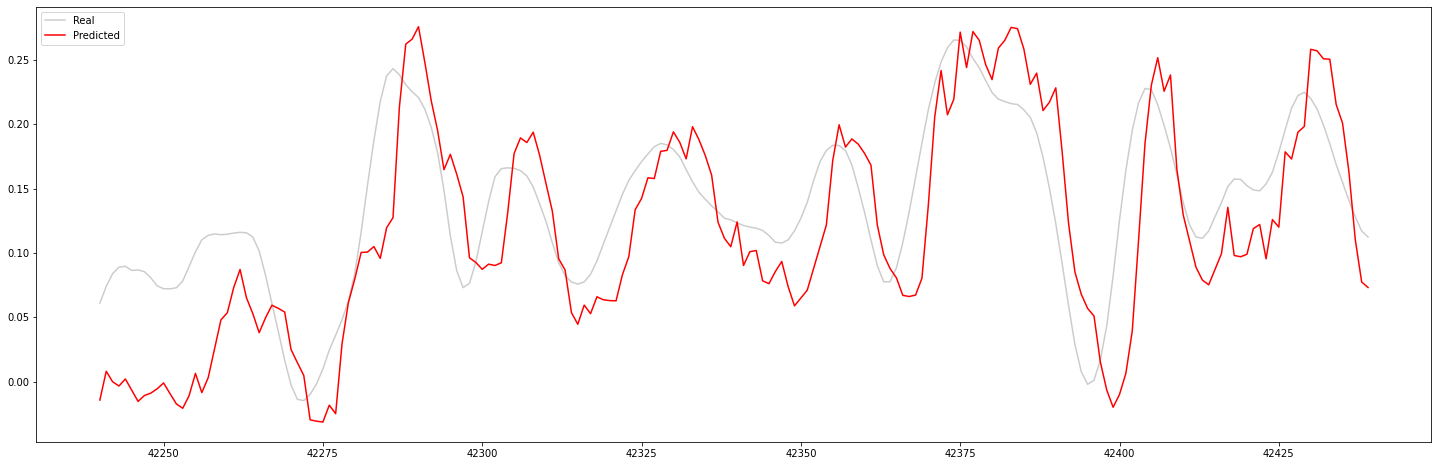

In [43]:
fig, ax = plt.subplots(1, figsize=(25,8))
ind=200


ax.plot(list(range(len(y.reshape(1,-1)[0])))[-ind:],y.reshape(1,-1)[0][-ind:], color='black',label='Real',alpha=0.2)
ax.plot(list(range(len(y.reshape(1,-1)[0])))[-ind:],model.predict(X).reshape(1,-1)[0][-ind:], color='red',label='Predicted')
ax.legend(loc="upper left")

In [118]:
import requests
response = requests.get(f'https://crypto-api.zlochteam.com/get-BTC-tweets').json()
print(f'{response["total"]} records in the dataset')

df_tweets = pd.DataFrame(response['data'])
df_tweets['Date'] = df_tweets['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tweets = df_tweets.set_index('Date')
df_tweets = df_tweets.sort_index(axis=0)
df_tweets.head()

response = requests.get(f'https://crypto-api.zlochteam.com/get-trading-view-indicators').json()
print(f'{response["total"]} records in the dataset')

df_tvta = pd.DataFrame(response['data'])
df_tvta['Date'] = df_tvta['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tvta = df_tvta.set_index('Date')
df_tvta = df_tvta.sort_index(axis=0)
df_tvta.head()

6027 records in the dataset
58738 records in the dataset


,buy,neutral,sell,symbol,timestamp
Date,,,,,
2022-05-28 15:20:20,14,9,3,BTC,1653744020
2022-05-28 15:21:20,14,9,3,BTC,1653744080
2022-05-28 15:22:20,14,9,3,BTC,1653744140
2022-05-28 15:23:21,14,10,2,BTC,1653744201
2022-05-28 15:24:21,15,10,1,BTC,1653744261


In [137]:
df = df.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df_tweets = df_tweets.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df_tvta = df_tvta.loc[pd.to_datetime(df.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df.head()

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff
Date,,,,,,,,,
2022-05-28 00:00:00,1734.24,1755.00,1726.79,1742.14,18819.20220,1653688800,-0.001045,-0.001593,-0.000423
2022-05-28 01:00:00,1742.13,1744.99,1703.00,1727.27,52023.46466,1653692400,-0.000504,-0.001406,-0.000015
2022-05-28 02:00:00,1727.26,1749.33,1722.26,1748.38,34782.29610,1653696000,-0.000256,-0.001062,0.000496
2022-05-28 03:00:00,1748.37,1752.39,1726.59,1730.26,34334.59350,1653699600,0.000194,-0.000580,0.001013
2022-05-28 04:00:00,1730.26,1741.97,1722.94,1729.38,21472.21510,1653703200,-0.000208,-0.000033,0.001373


In [171]:
def generateHourlyDataFormTweets(tweet_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tweet_df['join_key'] = tweet_df.apply(createJoinKey, axis=1)
    tweet_df = tweet_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tweet_df['Date']=tweet_df.apply(recreateDates, axis=1)
    tweet_df = tweet_df.set_index('Date').sort_index(axis=0)
    return tweet_df.drop(columns=['join_key','timestamp'])
    
df_tweets = generateHourlyDataFormTweets(df_tweets)
df_tweets

,mean subjectivity,negative,neutral,positive
Date,,,,
2022-05-28 00:00:00,1.806284,66.0,268,266
2022-05-28 01:00:00,1.874306,79.0,261,260
2022-05-28 02:00:00,1.992644,60.0,231,309
2022-05-28 03:00:00,1.966705,70.0,266,264
2022-05-28 04:00:00,2.094448,70.0,243,286
...,...,...,...,...
2022-07-07 19:00:00,2.344846,34.0,143,423
2022-07-07 20:00:00,2.445255,25.0,139,436
2022-07-07 21:00:00,2.264426,49.0,165,385


In [173]:
def generateHourlyDataFormTVTA(tvta_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tvta_df['join_key'] = tvta_df.apply(createJoinKey, axis=1)
    tvta_df = tvta_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tvta_df['Date']=tvta_df.apply(recreateDates, axis=1)
    tvta_df = tvta_df.set_index('Date').sort_index(axis=0)
    return tvta_df.drop(columns=['join_key','timestamp'])
    
df_tvta = generateHourlyDataFormTVTA(df_tvta)
df_tvta

,buy,neutral,sell
Date,,,
2022-05-28 15:00:00,425,367,248
2022-05-28 16:00:00,389,552,619
2022-05-28 17:00:00,531,534,495
2022-05-28 18:00:00,438,533,563
2022-05-28 19:00:00,270,542,748
...,...,...,...
2022-07-07 19:00:00,376,551,633
2022-07-07 20:00:00,859,488,213
2022-07-07 21:00:00,829,548,183


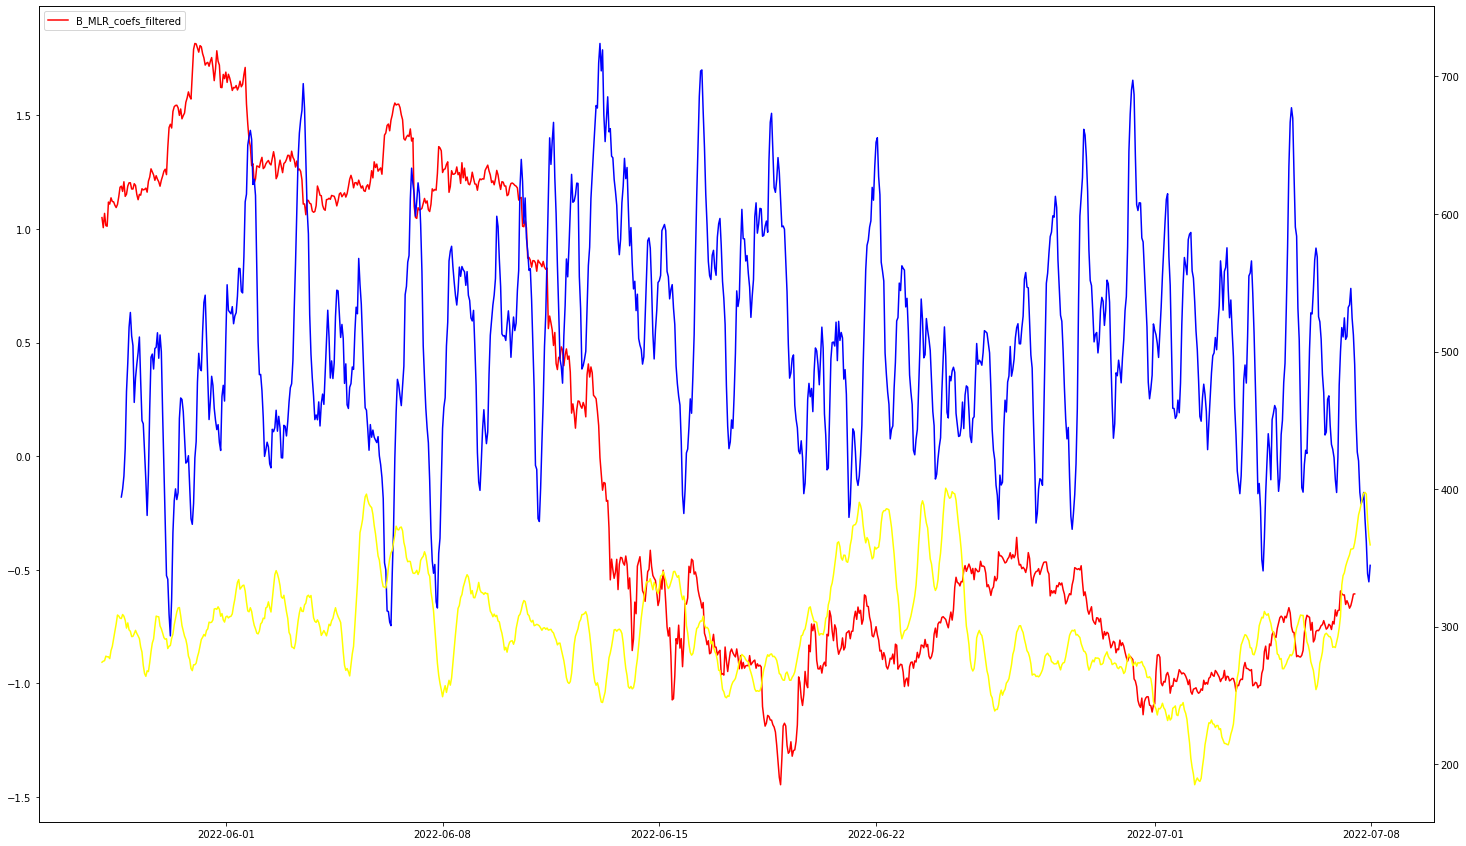

In [184]:
fig, ax_left = plt.subplots(1, figsize=(25,15))

ind = 170
#ax_left.plot(df_tweets.positive, color='yellow',label='Tweets')
ax_left.plot((df.Close-df.Close.mean())/df.Close.std(), color='red',label='B_MLR_coefs_filtered')
ax = ax_left.twinx()
ax.plot(df_tvta.index, savgol_filter(df_tvta.sell,20, 2, mode='nearest'), color='blue',label='df_tvta')
ax.plot(df_tweets.index, savgol_filter(df_tweets.positive,20, 2, mode='nearest'), color='yellow',label='Tweets')

ax_left.legend(loc="upper left")

In [130]:
import pywt

def lowpassfilter(signal, thresh = 0.63, wavelet="db5"):#'sym5', 'coif5', 'bior2.4'
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    if len(signal) % 2==0:
        return reconstructed_signal
    else:
        return reconstructed_signal[1:]

In [125]:
import requests
response = requests.get(f'https://crypto-api.zlochteam.com/get-BTC-tweets').json()
print(f'{response["total"]} records in the dataset')

df_tweets = pd.DataFrame(response['data'])
df_tweets['Date'] = df_tweets['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tweets = df_tweets.set_index('Date')
df_tweets = df_tweets.sort_index(axis=0)
df_tweets.head()

response = requests.get(f'https://crypto-api.zlochteam.com/get-trading-view-indicators').json()
print(f'{response["total"]} records in the dataset')

df_tvta = pd.DataFrame(response['data'])
df_tvta['Date'] = df_tvta['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tvta = df_tvta.set_index('Date')
df_tvta = df_tvta.sort_index(axis=0)
df_tvta.head()



455 records in the dataset
3192 records in the dataset


,buy,neutral,sell,symbol,timestamp
Date,,,,,
2022-05-28 15:20:20,14,9,3,BTC,1653744020
2022-05-28 15:21:20,14,9,3,BTC,1653744080
2022-05-28 15:22:20,14,9,3,BTC,1653744140
2022-05-28 15:23:21,14,10,2,BTC,1653744201
2022-05-28 15:24:21,15,10,1,BTC,1653744261
